In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load in k-independent data
cells = pd.read_csv('data/cells_no_repeats.csv', index_col=[0])
synapses = pd.read_csv('data/synapses_w_ids.csv', index_col=[0])
print('Cells: ', cells.shape)
print('Synapses: ', synapses.shape)
display(cells.head())
display(synapses.head())

Cells:  (56209, 5)
Synapses:  (5421809, 18)


,cell_type,pt_root_id,pt_x,pt_y,pt_z
Unnamed: 0,,,,,
0,23P,864691135639004475,71136,110528,20220
1,23P,864691135771677771,72576,108656,20291
2,23P,864691135864089470,79632,121456,16754
3,23P,864691135560505569,80128,124000,16563
4,23P,864691136315868311,80144,126928,16622


,pre_pt_root_id,post_pt_root_id,size,cell_type_pre,cb_x_pre,cb_y_pre,cb_z_pre,cell_type_post,cb_x_post,cb_y_post,cb_z_post,cb_x_diff,cb_y_diff,cb_z_diff,ctr_pt_x,ctr_pt_y,ctr_pt_z,synapse_id
0,864691135564683351,864691136811959667,960,23P,557.248,570.560,732.52,23P,791.744,483.968,780.44,-234.496,86.592,-47.92,637.608,371.352,720.20,0
1,864691135614119115,864691135508912649,7576,23P,774.720,504.960,895.68,23P,807.936,459.584,870.28,-33.216,45.376,25.40,805.376,488.376,863.60,1
3,864691135113147801,864691136022555784,684,23P,883.072,451.456,817.84,23P,851.520,483.840,759.96,31.552,-32.384,57.88,858.328,516.648,775.88,3
4,864691135194393642,864691135341362885,23172,23P,781.248,449.984,696.88,23P,798.720,465.152,758.56,-17.472,-15.168,-61.68,789.400,478.040,691.00,4
5,864691136272938174,864691135683554546,3660,23P,762.368,473.792,773.68,23P,820.352,446.784,719.08,-57.984,27.008,54.60,756.624,440.928,710.60,5


In [35]:
# Specify k
k = 6

In [21]:
# Load k-dependent data
clusters = pd.read_csv(f'data/synapse_clusters/clusters_ind_cntr_k{k}.csv', index_col=[0])
print(clusters.shape)
display(clusters.head())

(110784, 10)


,cluster_id,synapse_id_0,synapse_id_1,synapse_id_2,density_score,post_pt_root_id,post_cell_type,centroid_x,centroid_y,centroid_z
0,0,917488,974986,974273,0.808048,864691134884741370,4P,490.020000,719.154667,999.173333
1,1,979837,932857,958004,0.773447,864691134884741370,4P,580.260000,694.477333,1055.706667
2,2,252929,256608,236471,1.203239,864691134884742138,4P,425.456000,549.329333,815.586667
3,3,662648,704519,674327,0.860794,864691134884742906,6P-IT,488.977333,880.410667,938.493333
4,4,687987,670465,692136,0.980259,864691134884742906,6P-IT,557.716000,998.632000,1031.613333


In [22]:
"""
1| Get the synapses we've already seen
2| Mark all synapses in the group as seen
3| Move on to the next group
"""

"\n1| Get the synapses we've already seen\n2| Mark all synapses in the group as seen\n3| Move on to the next group\n"

In [23]:
# Count the number of synapses that appear in multiple clusters
repeats = set()
seen = set()
for i in range(k):
    new_repeats = clusters[clusters[f'synapse_id_{i}'].isin(seen)]
    repeats = repeats.union(new_repeats[f'synapse_id_{i}'].values)
    seen = seen.union(clusters[f'synapse_id_{i}'].values)
print(f'Overlap Analysis for k = {k}')
print('---------------------------')
print(f'Synapses repeated: {len(repeats)}')
print(f'Total unique synapses: {len(seen)}')
print(f'Percent unique: {100 - len(repeats) / len(seen) * 100}%')
print(f'Percent overlap: {len(repeats) / len(seen) * 100}%')

Overlap Analysis for k = 3
---------------------------
Synapses repeated: 20198
Total unique synapses: 303529
Percent unique: 93.34561112776703%
Percent overlap: 6.654388872232967%


In [24]:
# NOTE: This cell made the kernal crash for some reason, had to use the code above instead
# # Add a column to clusters with the post synaptic cell type
# clusters['post_cell_type'] = clusters['post_pt_root_id'].apply(lambda x: cells.loc[cells['pt_root_id'] == x, 'cell_type'])
# clusters.head()

In [25]:
# Group synapses by post-synaptic cell type
synapses_by_ct = synapses.groupby('cell_type_post')
clusters_by_ct = clusters.groupby('post_cell_type')

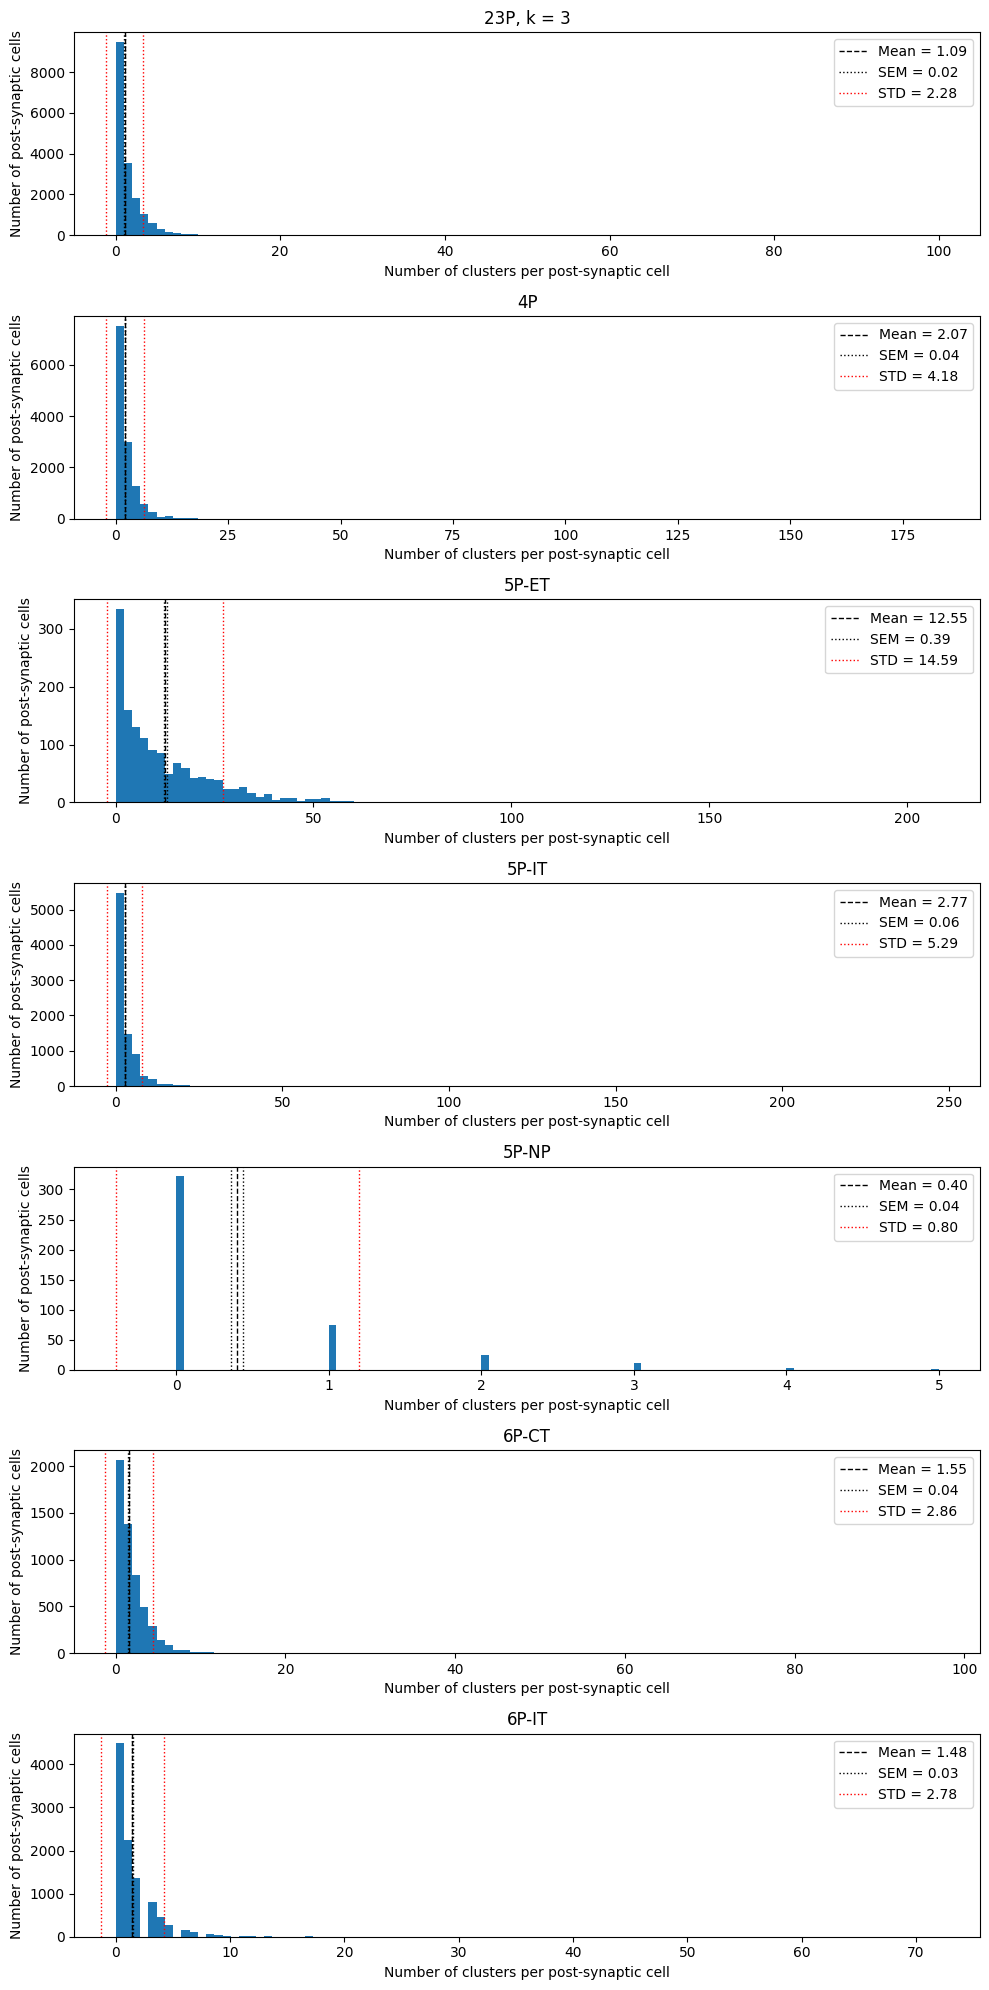

In [26]:
# Plot the distribution of the number of clusters per post-synaptic cell for each cell type
# Record values and bins for future cdfs
fig, axs = plt.subplots(7, 1, figsize=(10, 20))
values_bins = []
for i, (ct, synapses_ct) in enumerate(synapses_by_ct):
    synapses_by_post = synapses_ct.groupby('post_pt_root_id')
    clusters = clusters_by_ct.get_group(ct)

    clusters_per_post = synapses_by_post.apply(lambda x: len(clusters[clusters['post_pt_root_id'] == x.name]))

    clusters_mean = clusters_per_post.mean()
    clusters_std = clusters_per_post.std()
    clusters_sem = clusters_std / np.sqrt(len(clusters_per_post))

    values, bins, _ = axs[i].hist(clusters_per_post, bins=100)
    axs[i].axvline(clusters_mean, color='black', linestyle='dashed', linewidth=1, label=f'Mean = {clusters_mean:.2f}')
    axs[i].axvline(clusters_mean + clusters_sem, color='black', linestyle='dotted', linewidth=1, label=f'SEM = {clusters_sem:.2f}')
    axs[i].axvline(clusters_mean - clusters_sem, color='black', linestyle='dotted', linewidth=1)
    axs[i].axvline(clusters_mean + clusters_std, color='red', linestyle='dotted', linewidth=1, label=f'STD = {clusters_std:.2f}')
    axs[i].axvline(clusters_mean - clusters_std, color='red', linestyle='dotted', linewidth=1)
    if i == 0:
        axs[i].set_title(f'{ct}, k = {k}')
    else:
        axs[i].set_title(ct)
    axs[i].set_xlabel('Number of clusters per post-synaptic cell')
    axs[i].set_ylabel('Number of post-synaptic cells')
    axs[i].legend()
    values_bins.append((values, bins))
plt.tight_layout()
plt.show()
# fig.savefig(f'plots/cluster_distribution_k{k}.png')

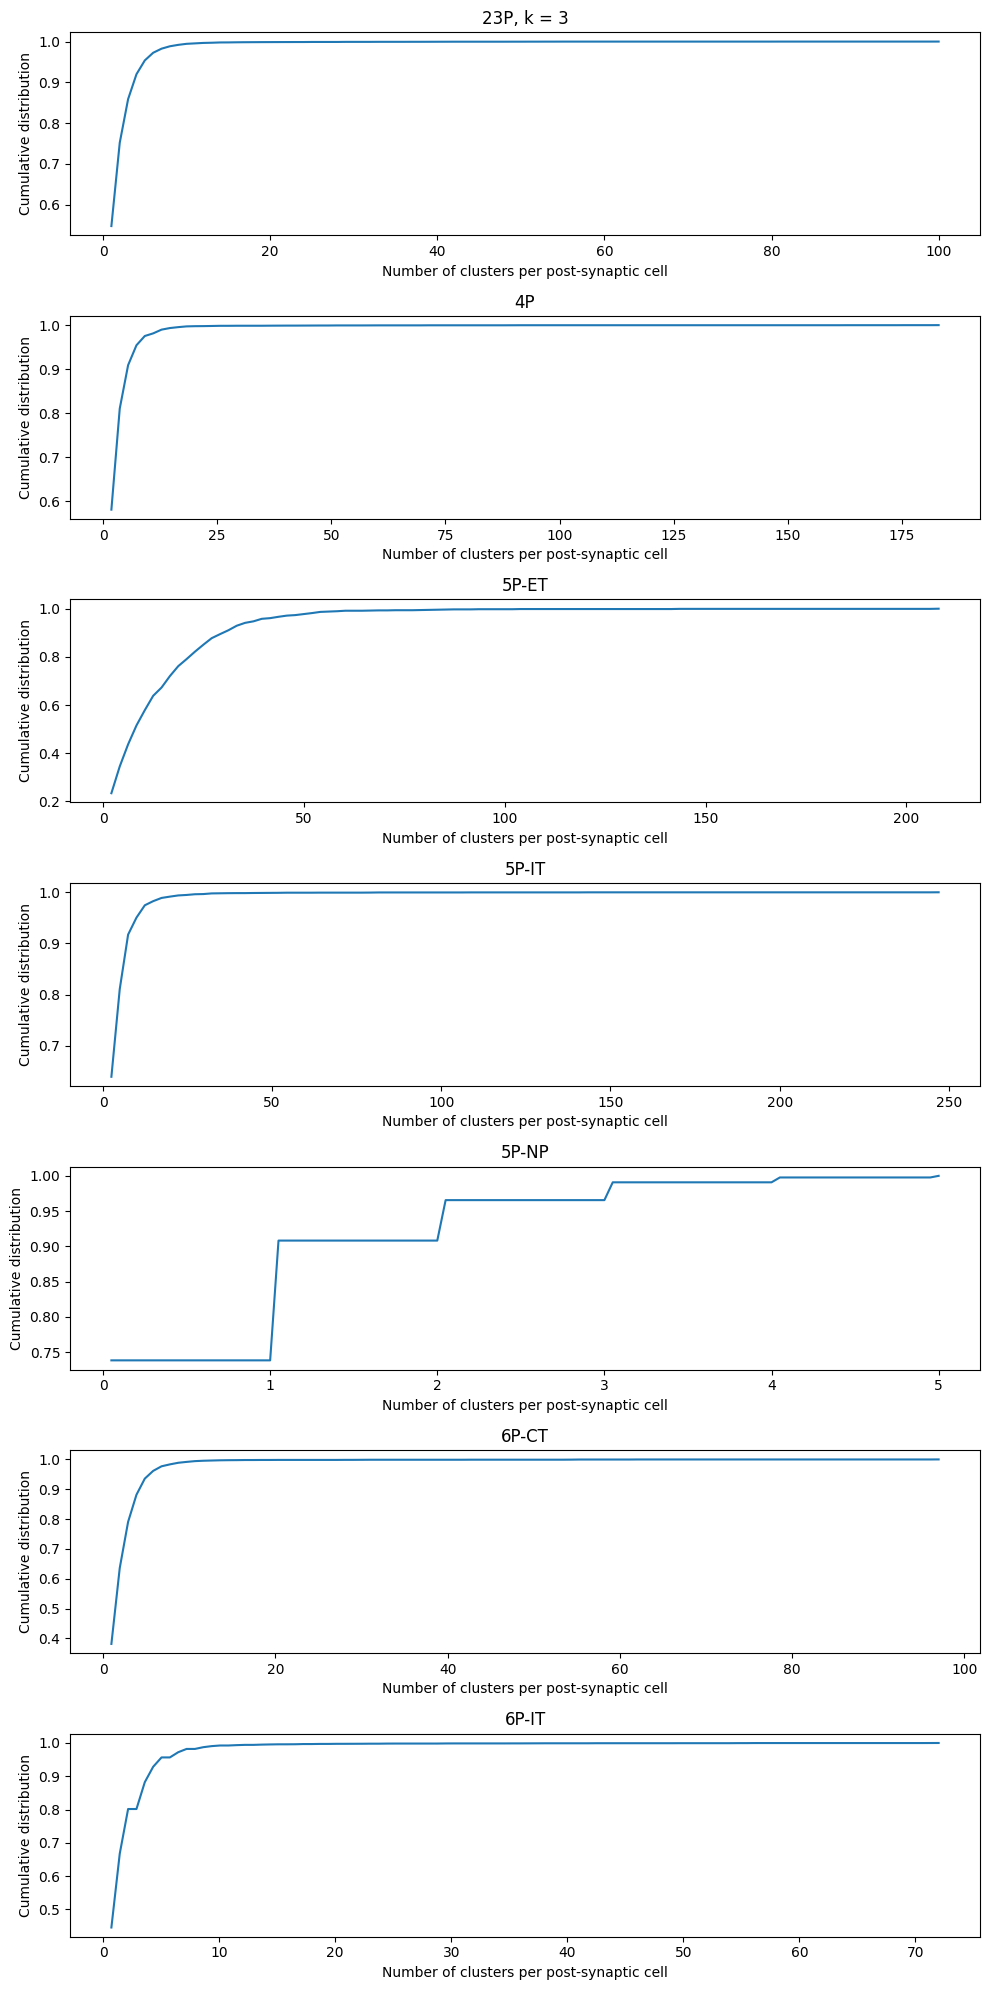

In [27]:
# Plot the cdf of the number of clusters per post-synaptic cell for each cell type
fig, axs = plt.subplots(7, 1, figsize=(10, 20))
for i, (ct, clusters) in enumerate(clusters_by_ct):
    axs[i].plot(values_bins[i][1][1:], np.cumsum(values_bins[i][0]) / np.sum(values_bins[i][0]))
    if i == 0:
        axs[i].set_title(f'{ct}, k = {k}')
    else:
        axs[i].set_title(ct)
    axs[i].set_xlabel('Number of clusters per post-synaptic cell')
    axs[i].set_ylabel('Cumulative distribution')
plt.tight_layout()
plt.show()
# fig.savefig(f'plots/cluster_cdf_k{k}.png')

In [38]:
k = 3

In [39]:
density_samples = pd.read_pickle(f'data/synapse_clusters/density_samples/density_samples_k{k}.pkl')
print("Density Cutoff for k =", k)
print(np.percentile(density_samples, 95))
# density = k / max(pairwise_distances) ~ synapses / unit distance

Density Cutoff for k = 3
0.7161785861617342


In [40]:
3/0.71

4.225352112676057